In [1]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

from bokeh.plotting import figure
from bokeh.io import push_notebook, show, output_notebook
from bokeh.models import ColumnDataSource
from bokeh.models.widgets import Div
from bokeh.layouts import row, column
from bokeh.palettes import Colorblind
from  ipywidgets import interact
output_notebook()


Loading BokehJS ...

<font color="red"> text text text </font>

(80, 80, 3)


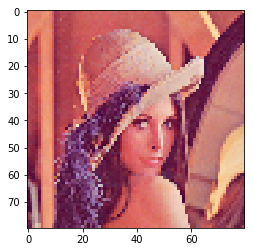

In [2]:
img = Image.open('images/lenna.png')
img = img.resize(size=(80,80))
img_mtx = np.array(img)

print(img_mtx.shape)
plt.imshow(img_mtx)

In [50]:
def diffuse(t, x, p):
    x = x.reshape(p['size'])   
    dxdt = np.zeros(p['size'])
    
    # diffusion constant decreases with time
    p['D'] = [p['D'][i]*(1-t/p['t_tot']) for i in range(len(p['D']))]
                
    for r in range(p['size'][0]):
        for c in range(p['size'][1]):
            
            diffusion = [None]*p['size'][2]
            for i in range(p['size'][2]):
                # left boundary
                if r == 0:
                    diffusion_row = p['D'][i]/p['dr']**2 * (           - x[r,c,i] + x[r+1,c,i])
                # right boundary
                elif r == p['size'][0]-1:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_row = p['D'][i]/p['dr']**2 * (x[r-1,c,i] - 2*x[r,c,i] + x[r+1,c,i])
                # upper boundary
                if c == 0:
                    diffusion_col = p['D'][i]/p['dc']**2 * (           - x[r,c,i] + x[r,c+1,i])
                # lower boundary
                elif c == p['size'][1]-1:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - x[r,c,i])
                # bulk
                else:
                    diffusion_col = p['D'][i]/p['dc']**2 * (x[r,c-1,i] - 2*x[r,c,i] + x[r,c+1,i])
                
                # total diffusion in two dimensions
                diffusion[i] = diffusion_row + diffusion_col
            
            # red preys on green preys on blue preys on red
            dxdt[r,c,0] = diffusion[0] + p['k3']*x[r,c,0]*x[r,c,1] - p['k1']*x[r,c,2]*x[r,c,0]
            dxdt[r,c,1] = diffusion[1] + p['k2']*x[r,c,1]*x[r,c,2] - p['k4']*x[r,c,0]*x[r,c,1]  
            dxdt[r,c,2] = diffusion[2] + p['k4']*x[r,c,2]*x[r,c,0] - p['k3']*x[r,c,1]*x[r,c,2]
            

    return dxdt.ravel()
                       
def eulerForward(dxdt, x, t_span, p):
    
    x_span = np.zeros((len(x), len(t_span)+1))
    x_span[:,0] = x
    
    for it,t in enumerate(tqdm(t_span)):
        x += dxdt(t, x, p)
        x_span[:,it+1] = x
        
    return x_span[:,:-1]
    
t_span = np.arange(0,15,0.1)
x0 = img_mtx.ravel()/255 
p = {'t_tot': t_span[-1],
     'size': img_mtx.shape,
     'dr': 1,
     'dc': 1,
     'D': [0.05, 0.05, 0.05],
     'k1': 0.20,
     'k2': 0.15,
     'k3': 0.10,
     'k4': 0.05}


img_development = eulerForward(diffuse, x0, t_span, p)


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.85it/s]


In [44]:
def convert2img(x, size, slope=5.5, intercept=3):
    # reshape
    x = x.reshape(size)
    
    # rescale into (0,1)
    x = 1/(1 + np.exp(-slope*x+intercept))    
    #x = np.clip(x, 0, 1)
    
    # rescale into (0,255) ints
    x *= 255
    x = x.astype(np.uint8)
    
    # add transparency channel and set each val to 255 (no transparency)
    x = np.concatenate((x, 255*np.ones((size[0], size[1], 1), dtype=np.uint8)), axis=2)
    
    return  x

x = img_development.T[0]
img_data = ColumnDataSource({'img': [convert2img(x, p['size'])]})

pb = figure(x_range=(0,p['size'][0]), y_range=(0,p['size'][1]),
            plot_width=p['size'][0]*4, plot_height=p['size'][1]*4)

r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][0], dh=p['size'][1])
show(pb, notebook_handle=True)

def update(slope=5.5, intercept=3):
    r.data_source.data['img'] = [np.flipud(convert2img(x, p['size'], 
                                                       slope=slope, intercept=intercept))]
    push_notebook()
    
    
interact(update, slope=(-10, 10, 0.1), intercept=(-10, 10, 0.1))

interactive(children=(FloatSlider(value=5.5, description='slope', max=10.0, min=-10.0), FloatSlider(value=3.0, description='intercept', max=10.0, min=-10.0), Output()), _dom_classes=('widget-interact',))

<function __main__.update>

In [51]:
img_data = ColumnDataSource({'img': [np.flipud(convert2img(img_development.T[0], p['size']))]})

pb = figure(x_range=(0,p['size'][0]), y_range=(0,p['size'][1]),
            plot_width=p['size'][0]*4, plot_height=p['size'][1]*4)

r = pb.image_rgba(image='img', source=img_data, x=0, y=0, dw=p['size'][0], dh=p['size'][1])
show(pb, notebook_handle=True)

def update(t=0):
    r.data_source.data['img'] = [np.flipud(convert2img(img_development.T[t], p['size']))]
    push_notebook()
    
    
interact(update, t=(0,len(t_span)-1,1))

interactive(children=(IntSlider(value=0, description='t', max=149), Output()), _dom_classes=('widget-interact',))

<function __main__.update>